In [1]:
from astropy.wcs import WCS
from sqlite3 import connect
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from astroquery.vizier import Vizier
import pandas as pd
import sqlite3
import numpy as np
from collections import defaultdict
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as plp


from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import umap.umap_ as umap

from sklearn.metrics import confusion_matrix, fbeta_score, mean_squared_log_error

import Image_module as im

In [2]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


fbeta_scorer = make_scorer(fbeta_score, beta=.5, pos_label=1) 


def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=10, scoring=fbeta_scorer,
    )
    
    return np.mean(score)

## Загрузка каталогов

In [3]:
field_center = SkyCoord(243.9021249*u.deg, 14.41539495*u.deg)
region_width = region_height = 2000*u.arcsec

Первый каталог

In [4]:
con = sqlite3.connect('catalogs.db')

cat1 = 'ps'
df1 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat1, cat1 + '_RA', cat1 + '_DE'),
                        con,
                        params = [field_center.ra.value - region_width.value/7200 - 30/3600,
                                  field_center.ra.value + region_width.value/7200 + 30/3600,
                                  field_center.dec.value - region_height.value/7200 - 30/3600,
                                  field_center.dec.value + region_height.value/7200 + 30/3600])

df1.rename(columns={df1.columns[1]: 'RA1',
                    df1.columns[2]: 'e_RA1',
                    df1.columns[3]: 'DE1',
                    df1.columns[4]: 'e_DE1',
                    df1.columns[5]: 'g1',
                    df1.columns[6]: 'e_g1',
                    df1.columns[7]: 'r1',
                    df1.columns[8]: 'e_r1',
                    df1.columns[9]: 'i1',
                    df1.columns[10]: 'e_i1',
                    df1.columns[11]: 'z1',
                    df1.columns[12]: 'e_z1',
                    df1.columns[13]: 'y1',
                    df1.columns[14]: 'e_y1'}, inplace=True)
df1

,ps_objID,RA1,e_RA1,DE1,e_DE1,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1
0,124952436771075990,243.677088,0.0047,14.129561,0.0048,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385
1,124952436666856575,243.666660,0.0025,14.130038,0.0084,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342
2,124952436734606306,243.673429,0.0105,14.129818,0.0105,NaN,NaN,19.5359,0.0306,NaN,NaN,NaN,NaN,NaN,NaN
3,124952436561437625,243.656096,0.0247,14.131002,0.0247,20.3008,0.0286,19.3910,0.0382,NaN,NaN,NaN,NaN,NaN,NaN
4,124952436557988107,243.655767,0.0022,14.131308,0.0021,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10072,125642437979351460,243.797862,0.1132,14.700724,0.1917,NaN,NaN,NaN,NaN,21.9080,0.0430,21.2086,0.1566,NaN,NaN
10073,125622437426049508,243.742582,0.0059,14.690790,0.0100,21.0542,0.0336,19.8407,0.0155,18.4057,0.0040,17.7475,0.0083,17.4364,0.0088
10074,125632437447642402,243.744736,0.0339,14.693297,0.0555,NaN,NaN,22.1187,0.0987,21.3530,0.0428,20.7234,0.1105,NaN,NaN
10075,125632437437174557,243.743808,0.0389,14.695093,0.0389,NaN,NaN,20.6888,0.0622,NaN,NaN,NaN,NaN,NaN,NaN


Второй

In [5]:
cat2 = 'sdss'

df2 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat2, cat2 + '_RA', cat2 + '_DE'),
                        con,
                        params = [field_center.ra.value - region_width.value/7200 - 30/3600,
                                  field_center.ra.value + region_width.value/7200 + 30/3600,
                                  field_center.dec.value - region_height.value/7200 - 30/3600,
                                  field_center.dec.value + region_height.value/7200 + 30/3600])

df2.rename(columns={df2.columns[1]: 'RA2',
                    df2.columns[2]: 'e_RA2',
                    df2.columns[3]: 'DE2',
                    df2.columns[4]: 'e_DE2',
                    df2.columns[5]: 'u2',
                    df2.columns[6]: 'e_u2',
                    df2.columns[7]: 'g2',
                    df2.columns[8]: 'e_g2',
                    df2.columns[9]: 'r2',
                    df2.columns[10]: 'e_r2',
                    df2.columns[11]: 'i2',
                    df2.columns[12]: 'e_i2',
                    df2.columns[13]: 'z2',
                    df2.columns[14]: 'e_z2'}, inplace=True)
df2

,sdss_objID,RA2,e_RA2,DE2,e_DE2,u2,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,1237668337398710754,243.677075,0.009,14.129574,0.009,21.389,0.098,20.155,0.018,19.654,0.017,19.388,0.019,19.233,0.046
1,1237665530651148867,243.677052,0.009,14.129573,0.010,21.763,0.133,20.212,0.019,19.648,0.015,19.402,0.019,19.305,0.062
2,1237665530651148771,243.666634,0.006,14.130073,0.005,21.212,0.086,19.553,0.013,18.941,0.010,18.687,0.012,18.578,0.034
3,1237668337398710745,243.666653,0.006,14.130071,0.005,21.075,0.077,19.591,0.013,18.929,0.011,18.677,0.012,18.604,0.028
4,1237668337398710456,243.655770,0.002,14.131354,0.001,17.763,0.012,16.801,0.005,16.449,0.004,16.309,0.005,16.273,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20541,1237668337935581878,243.744749,0.128,14.693339,0.148,25.885,0.530,23.259,0.197,22.272,0.162,21.272,0.095,20.810,0.212
20542,1237665548902270118,243.744800,0.138,14.693313,0.141,25.427,0.891,23.453,0.296,22.587,0.186,21.301,0.092,20.782,0.232
20543,1237665548902269649,243.745566,0.131,14.699052,0.139,23.597,0.850,22.636,0.158,22.395,0.170,21.787,0.151,21.529,0.463
20544,1237665548902270325,243.747638,0.197,14.701063,0.131,24.224,1.286,25.431,0.786,22.654,0.237,21.498,0.131,21.055,0.350


Планируемые пояснения

In [6]:
coords1 = SkyCoord(df1.RA1.values.astype(float), df1.DE1.values.astype(float), unit = [u.deg]*2)
coords2 = SkyCoord(df2.RA2.values.astype(float), df2.DE2.values.astype(float), unit = [u.deg]*2)
seplim = .5*u.arcsec
res = search_around_sky(coords1, coords2, seplimit = seplim)

In [7]:
# наблюдение

c1, c2 = np.unique(res[0], return_counts = True)
print("{} объектa/ов из первого каталога имеют более одного соседа в радиусе {} угл.сек.".format(np.count_nonzero(1*(c2 > 1)), seplim.value, ))

7622 объектa/ов из первого каталога имеют более одного соседа в радиусе 0.5 угл.сек.


Первый класс

In [8]:
a1 = df1.iloc[res[0]]
a1.reset_index(inplace = True, drop=True)

a2 = df2.iloc[res[1]]
a2.reset_index(inplace = True, drop=True)

class1 = pd.concat([a1, a2], axis = 1)
class1['match'] = 1

# взаимно-однозначное соответствие
class1.drop(index = class1.loc[class1['RA1'].duplicated()].index, inplace = True) 
class1.drop(index = class1.loc[class1['RA2'].duplicated()].index, inplace = True)
class1

,ps_objID,RA1,e_RA1,DE1,e_DE1,g1,e_g1,r1,e_r1,i1,...,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,match
0,124952436771075990,243.677088,0.0047,14.129561,0.0048,20.1046,0.0169,19.6244,0.0038,19.3938,...,0.098,20.155,0.018,19.654,0.017,19.388,0.019,19.233,0.046,1
2,124952436666856575,243.666660,0.0025,14.130038,0.0084,19.5071,0.0231,18.9146,0.0071,18.6990,...,0.086,19.553,0.013,18.941,0.010,18.687,0.012,18.578,0.034,1
4,124952436557988107,243.655767,0.0022,14.131308,0.0021,16.7566,0.0046,16.4471,0.0029,16.3323,...,0.012,16.801,0.005,16.449,0.004,16.309,0.005,16.273,0.007,1
6,124952436644779395,243.664448,0.1188,14.132447,0.7978,NaN,NaN,NaN,NaN,21.8363,...,0.660,23.997,0.441,22.346,0.185,21.622,0.154,21.271,0.341,1
8,124962436622993179,243.662271,0.0024,14.135539,0.0151,19.1318,0.0223,18.7672,0.0045,18.6129,...,0.044,19.206,0.011,18.780,0.010,18.602,0.012,18.555,0.027,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16088,125632437899922226,243.789963,0.1130,14.693038,0.1434,NaN,NaN,22.4441,0.1778,21.3974,...,1.405,23.112,0.275,22.029,0.146,21.361,0.123,20.620,0.257,1
16092,125642437868121445,243.786808,0.0117,14.700836,0.0165,22.1753,0.0846,20.8488,0.0417,20.2330,...,0.461,22.263,0.120,20.706,0.042,20.027,0.036,19.653,0.098,1
16094,125622437426049508,243.742582,0.0059,14.690790,0.0100,21.0542,0.0336,19.8407,0.0155,18.4057,...,0.868,21.354,0.041,19.862,0.021,18.407,0.010,17.624,0.016,1
16096,125632437447642402,243.744736,0.0339,14.693297,0.0555,NaN,NaN,22.1187,0.0987,21.3530,...,0.530,23.259,0.197,22.272,0.162,21.272,0.095,20.810,0.212,1


Смотр первого класса

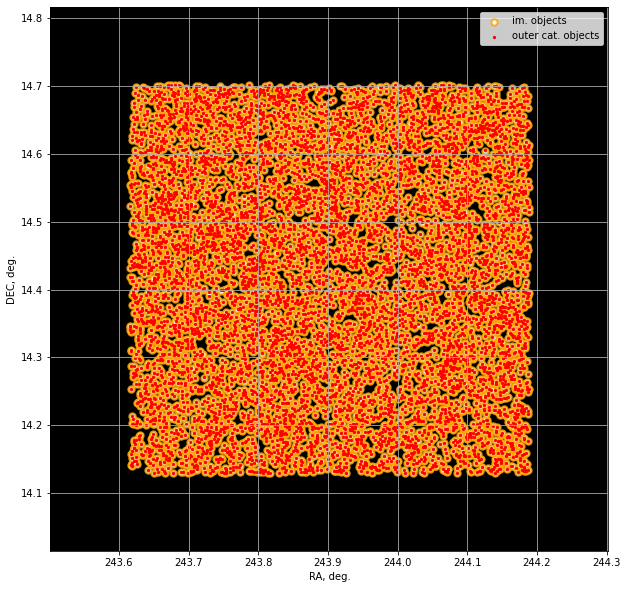

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(class1['RA1'].values.astype(float), class1['DE1'].values.astype(float), s=40, c='w', label='im. objects', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)

ax.scatter(class1['RA2'].values.astype(float), class1['DE2'].values.astype(float), s=5, color='r', label='outer cat. objects')


ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.grid()
plt.legend()

marg=-0.2
ax.margins(-marg, -marg)

Второй класс

In [10]:
r1 = np.random.randint(0, len(df1), len(class1)+1)
r2 = np.random.randint(0, len(df2), len(class1)+1)

b1 = df1.iloc[r1]
b1.reset_index(inplace = True, drop=True)

b2 = df2.iloc[r2]
b2.reset_index(inplace = True, drop=True)

class2 = pd.concat([b1, b2], axis = 1)
class2['match'] = 0
class2

,ps_objID,RA1,e_RA1,DE1,e_DE1,g1,e_g1,r1,e_r1,i1,...,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,match
0,125112439148799008,243.914835,0.1424,14.265447,0.1562,NaN,NaN,21.5426,0.1474,21.8238,...,1.091,23.701,0.352,21.614,0.088,21.099,0.095,21.394,0.478,0
1,125622438892400899,243.889158,0.1267,14.683545,0.1267,NaN,NaN,NaN,NaN,21.0859,...,0.383,21.299,0.040,20.623,0.031,20.391,0.039,20.469,0.164,0
2,125092437982755899,243.798254,0.0089,14.246190,0.0110,21.2476,0.0425,20.9348,0.0273,20.7651,...,0.749,24.434,0.494,23.968,0.448,22.368,0.196,22.884,0.594,0
3,125242436941499667,243.694128,0.0329,14.374275,0.0329,NaN,NaN,21.6254,0.0155,21.2482,...,0.387,24.185,0.386,22.950,0.206,21.796,0.132,20.630,0.193,0
4,124962436622993179,243.662271,0.0024,14.135539,0.0151,19.1318,0.0223,18.7672,0.0045,18.6129,...,0.305,23.379,0.358,23.500,0.683,21.119,0.125,20.919,0.361,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8072,125162437961006447,243.796080,0.1755,14.304976,0.1755,20.0894,0.0891,21.7863,0.2772,22.1947,...,0.442,21.972,0.066,21.119,0.053,20.760,0.055,20.371,0.137,0
8073,125102438655907789,243.865578,0.0087,14.256085,0.0134,20.9468,0.0632,20.5197,0.0164,20.2945,...,0.543,21.820,0.059,20.455,0.025,19.641,0.020,19.249,0.043,0
8074,125572436551044980,243.655181,0.1043,14.645271,0.1043,NaN,NaN,22.1393,0.1108,22.0461,...,0.712,23.004,0.251,21.965,0.136,21.565,0.167,21.379,0.410,0
8075,125152436868824681,243.686854,0.0743,14.295119,0.3069,NaN,NaN,NaN,NaN,21.6110,...,0.628,23.221,0.231,22.636,0.182,23.418,0.492,21.781,0.412,0


Проверим распределения угловых расстояний между объектами в сформированных классах. В первом классе установлены верные сопоставления между близкими друг к другу объектами, во втором компаньоны отбирались случайно

In [11]:
import lamy
from importlib import reload
lamy = reload(lamy)

sep1 = class1.apply(lamy.separation, axis = 1)
sep2 = class2.apply(lamy.separation, axis = 1)

Text(0.5, 0.98, 'Распределение угловых расстояний в сопоставленных парах двух классов')

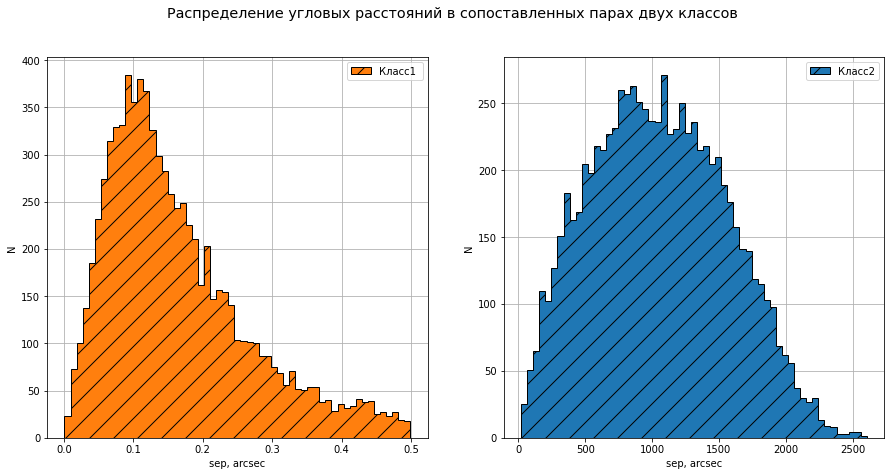

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))

k1,k2,k3=ax1.hist(sep1, histtype='step', bins=57, label='Класс1 ', color='C1', hatch='/', edgecolor='k', fill=True)
l1,l2,l3=ax2.hist(sep2, histtype='step', bins=57, label='Класс2', hatch='/', edgecolor='k', fill=True)

ax1.grid()
ax2.grid()

ax1.set_xlabel('sep, arcsec')
ax1.set_ylabel('N')

ax2.set_xlabel('sep, arcsec')
ax2.set_ylabel('N')

ax1.legend()
ax2.legend()

fig.suptitle('Распределение угловых расстояний в сопоставленных парах двух классов', fontsize="x-large")
# plt.xlim(-1,150)

Ок

In [185]:
data = pd.concat([class1.iloc[:, 5:15].join(class1.iloc[:, 20:]), class2.iloc[:, 5:15].join(class2.iloc[:, 20:])])
data.reset_index(inplace=True, drop=True)
data.dropna(inplace=True)
data

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,...,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,match
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385,...,0.098,20.155,0.018,19.654,0.017,19.388,0.019,19.233,0.046,1
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342,...,0.086,19.553,0.013,18.941,0.010,18.687,0.012,18.578,0.034,1
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055,...,0.012,16.801,0.005,16.449,0.004,16.309,0.005,16.273,0.007,1
4,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,18.5408,0.0090,18.5585,0.0176,...,0.044,19.206,0.011,18.780,0.010,18.602,0.012,18.555,0.027,1
7,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,18.5390,0.0115,18.4372,0.0204,...,0.204,20.132,0.018,19.088,0.012,18.696,0.012,18.510,0.026,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,19.5992,0.0242,19.3105,0.0134,...,0.440,23.393,0.235,23.170,0.318,21.885,0.156,22.471,0.584,0
16144,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,17.8211,0.0074,17.5721,0.0119,...,0.383,22.232,0.137,21.403,0.100,20.988,0.126,20.466,0.318,0
16145,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,19.3940,0.0345,19.2077,0.0463,...,1.491,22.695,0.188,23.280,0.417,22.223,0.236,21.013,0.309,0
16147,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,19.1681,0.0151,18.9094,0.0303,...,0.856,21.677,0.054,20.182,0.022,19.192,0.016,18.617,0.035,0


## Признаки

Каждая пара правильно (1) или неправильно (0) сопоставленных объектов представлена набором магнитуд $g_1, r_1, i_1, z_1$ первого объекта и $g_2, r_2, i_2, z_2$ второго, а так же набором приписанных магнитудам ошибок. Логично ввести признак, определяющий "расстояние" между объектами в пространстве griz: 

$$sep = \sqrt{(g_1 - g_2)^2 + (r_1 - r_2)^2 + (i_1 - i_2)^2 + (z_1 - z_2)^2}$$

In [186]:
X0 = data.copy()
X0['sep'] = np.sqrt((data.g1 - data.g2)**2 + (data.r1 - data.r2)**2 + (data.i1 - data.i2)**2 + (data.z1 - data.z2)**2 )
X0

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,...,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,match,sep
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385,...,20.155,0.018,19.654,0.017,19.388,0.019,19.233,0.046,1,0.094086
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342,...,19.553,0.013,18.941,0.010,18.687,0.012,18.578,0.034,1,0.056274
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055,...,16.801,0.005,16.449,0.004,16.309,0.005,16.273,0.007,1,0.056286
4,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,18.5408,0.0090,18.5585,0.0176,...,19.206,0.011,18.780,0.010,18.602,0.012,18.555,0.027,1,0.077395
7,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,18.5390,0.0115,18.4372,0.0204,...,20.132,0.018,19.088,0.012,18.696,0.012,18.510,0.026,1,0.213487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,19.5992,0.0242,19.3105,0.0134,...,23.393,0.235,23.170,0.318,21.885,0.156,22.471,0.584,0,4.061470
16144,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,17.8211,0.0074,17.5721,0.0119,...,22.232,0.137,21.403,0.100,20.988,0.126,20.466,0.318,0,4.643573
16145,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,19.3940,0.0345,19.2077,0.0463,...,22.695,0.188,23.280,0.417,22.223,0.236,21.013,0.309,0,3.476887
16147,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,19.1681,0.0151,18.9094,0.0303,...,21.677,0.054,20.182,0.022,19.192,0.016,18.617,0.035,0,1.114111


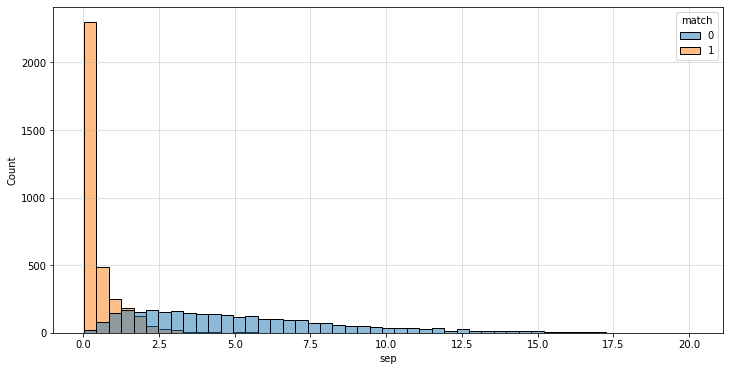

In [187]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(data=X0, x='sep', hue='match', alpha=.5)
ax.grid(alpha=.5)

Поскольку фильтры g, r, i и z, являются общими для обоих каталогов, верно сопоставленные объекты на графиках $f_{2} - f_{1}, f = g, r, i, z$ должны аппроксимироваться линейным законом

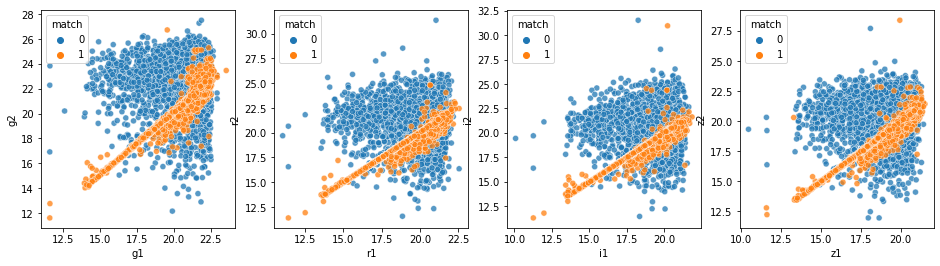

In [188]:
fig, ax = plt.subplots(1,4,figsize=(16, 4))

cols = ['g', 'r', 'i','z']

for i,state in enumerate(cols):
    x_ax = state + "1"
    y_ax = state + "2"

    sns.scatterplot(data=X0.loc[::-1, :], x=x_ax, y=y_ax, ax=ax[i], hue='match', alpha=.75, hue_order=[0, 1])

Аппроксимируем зависимости $f_{2}$ от $f_{1}, f=g, r, i, z$ линейным законом $ax+b$, в качестве признаков пары в каждом фильтре выберем расстояние d от наблюдаемой $(f_{1}, f_{2})$ до найденной прямой 

$$d_{f}=\frac{|a*f_{1}-f_{2}+b|}{a}, f=g, r, i, z$$

In [189]:
from sklearn.linear_model import LinearRegression
from scipy import stats

    # g фильтры сопоставленных объектов      # отработка пустых значений из g1
X_g = data.loc[data.match == 1].g1.loc[-data.loc[data.match == 1].g1.isna()].values.reshape(-1, 1)
Y_g = data.loc[data.match == 1].g2.loc[-data.loc[data.match == 1].g1.isna()].values

    # r фильтры сопоставленных объектов      # отработка пустых значений из r1
X_r = data.loc[data.match == 1].r1.loc[-data.loc[data.match == 1].r1.isna()].values.reshape(-1, 1)
Y_r = data.loc[data.match == 1].r2.loc[-data.loc[data.match == 1].r1.isna()].values

    # i фильтры сопоставленных объектов      # отработка пустых значений из i1
X_i = data.loc[data.match == 1].i1.loc[-data.loc[data.match == 1].i1.isna()].values.reshape(-1, 1)
Y_i = data.loc[data.match == 1].i2.loc[-data.loc[data.match == 1].i1.isna()].values

    # z фильтры сопоставленных объектов      # отработка пустых значений из z1
X_z = data.loc[data.match == 1].z1.loc[-data.loc[data.match == 1].z1.isna()].values.reshape(-1, 1)
Y_z = data.loc[data.match == 1].z2.loc[-data.loc[data.match == 1].z1.isna()].values

lr_g = LinearRegression().fit(X_g, Y_g)
lr_r = LinearRegression().fit(X_r, Y_r)
lr_i = LinearRegression().fit(X_i, Y_i)
lr_z = LinearRegression().fit(X_z, Y_z)

x_prob = np.arange(12, 24).reshape(-1,1)

<AxesSubplot:xlabel='z1', ylabel='z2'>

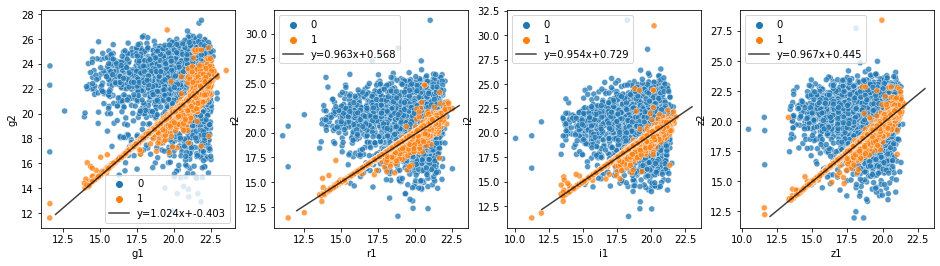

In [190]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

cols = ['g', 'r', 'i','z']

for i,state in enumerate(cols):
    x_ax = state + "1"
    y_ax = state + "2"

    sns.scatterplot(data=X0.loc[::-1, :], x=x_ax, y=y_ax, ax=ax[i], hue='match', alpha=.75, hue_order=[0, 1])

sns.lineplot(x=x_prob.reshape(1,-1)[0], y=lr_g.predict(x_prob), ax=ax[0], 
             label="y={0:.3f}x+{1:.3f}".format(lr_g.coef_[0], lr_g.intercept_), color='k', alpha=.75)

sns.lineplot(x=x_prob.reshape(1,-1)[0], y=lr_r.predict(x_prob), ax=ax[1],
             label="y={0:.3f}x+{1:.3f}".format(lr_r.coef_[0], lr_r.intercept_), color='k', alpha=.75)

sns.lineplot(x=x_prob.reshape(1,-1)[0], y=lr_i.predict(x_prob), ax=ax[2],
             label="y={0:.3f}x+{1:.3f}".format(lr_i.coef_[0], lr_i.intercept_), color='k', alpha=.75)

sns.lineplot(x=x_prob.reshape(1,-1)[0], y=lr_z.predict(x_prob), ax=ax[3],
             label="y={0:.3f}x+{1:.3f}".format(lr_z.coef_[0], lr_z.intercept_), color='k', alpha=.75)

Аппроксимируем зависимости $f_{2}$ от $f_{1}, f=g, r, i, z$ линейным законом $ax+b$, в качестве признаков пары в каждом фильтре выберем расстояние d от наблюдаемой $(f_{1}, f_{2})$ до найденной прямой 

$$d_{f}=\frac{|a*f_{1}-f_{2}+b|}{a}, f=g, r, i, z$$

In [191]:
def dist(row):
    d_g = abs(lr_g.coef_[0]*row.g1 - row.g2 + lr_g.intercept_)/lr_g.coef_[0]
    d_r = abs(lr_r.coef_[0]*row.r1 - row.g2 + lr_r.intercept_)/lr_r.coef_[0]
    d_i = abs(lr_i.coef_[0]*row.i1 - row.g2 + lr_i.intercept_)/lr_i.coef_[0]
    d_z = abs(lr_z.coef_[0]*row.z1 - row.g2 + lr_z.intercept_)/lr_z.coef_[0]
    
    return d_g, d_r, d_i, d_z

In [192]:
dd = dist(X0)

X0['d_g'] = dd[0]
X0['d_r'] = dd[1]
X0['d_i'] = dd[2]
X0['d_z'] = dd[3]

X0['dd'] = np.sqrt(dd[0]**2 + dd[1]**2 + dd[2]**2 + dd[3]**2) # ещё один признак - "суммарное расстояние" 

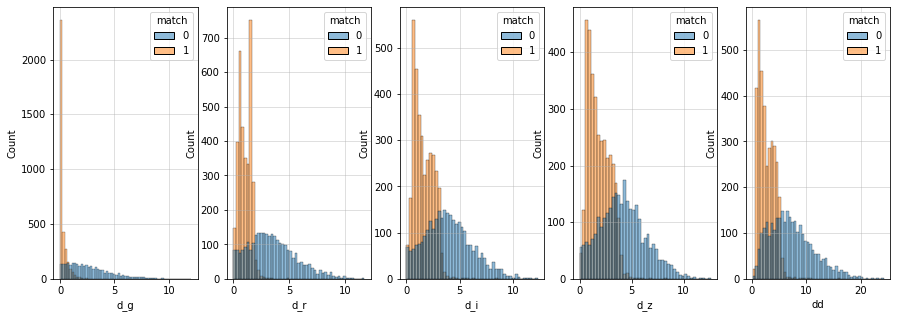

In [193]:
cols2 = ['d_g', 'd_r', 'd_i', 'd_z', 'dd']

fig, ax = plt.subplots(1,5,figsize=(15,5))

for i, state in enumerate(cols2):
    
    sns.histplot(data=X0, x=state, ax=ax[i], hue='match', alpha=.5)
    ax[i].grid(alpha=.5)

Так же важным параметром, характеризующим объект, являются показатели цвета: g-r, r-i 

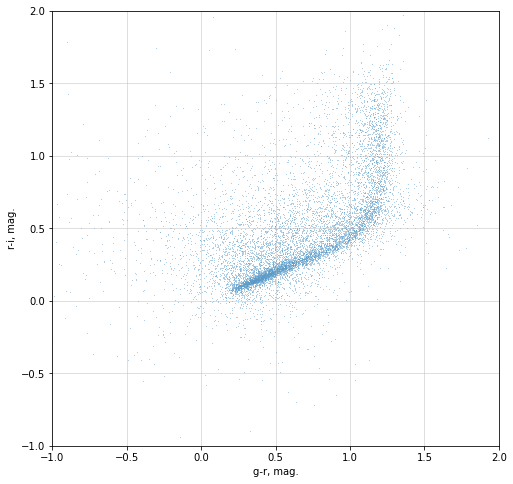

In [196]:
#Загрузим побольше объектов из каталога PanSTARRS для построения диграмы цвет-цвет

outer_cat = Vizier(catalog='PanSTARRS', row_limit=-1).query_region(field_center,   
                                                        width=region_width + 1000*u.arcsec,
                                                        height=region_height + 1000*u.arcsec)[0]

outer_cat['x'] = outer_cat['gmag'] - outer_cat['rmag']
outer_cat['y'] = outer_cat['rmag'] - outer_cat['imag']
# outer_cat['x2'] = outer_cat['imag'] - outer_cat['gmag']
# outer_cat['y2'] =  outer_cat['zmag'] - outer_cat['rmag']

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x=outer_cat['x'], y=outer_cat['y'], s=.5, ax=ax)
# sns.scatterplot(x=outer_cat['x2'], y=outer_cat['y2'], s=.5, ax=ax[1])

ax.set_xlabel('g-r, mag.')
# ax[1].set_xlabel('g-r, mag.')

ax.set_ylabel('r-i, mag.')
# ax[1].set_ylabel('i-z, mag.')

ax.set_xlim(-1,2)
ax.set_ylim(-1,2)

# ax[1].set_xlim(-.5,1.5)
# ax[1].set_ylim(-1.5,.5)

ax.grid(alpha=.5)
# ax[1].grid(alpha=.5)

Добавим признак, определяющий расстояние между объектами на диаграмме показателей цвета


$$CI = \sqrt{(g_1-r_1-g_2+r_2)^2 + (r_1-i_1-r_2+i_2)^2}$$

In [197]:
X0['color_index'] = np.sqrt((data.g1 - data.r1 - data.g2 + data.r2)**2 + (data.r1 - data.i1 - data.r2 + data.i2)**2)
X0

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,...,z2,e_z2,match,sep,d_g,d_r,d_i,d_z,dd,color_index
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385,...,19.233,0.046,1,0.094086,0.034901,0.704846,0.966319,1.070175,1.605327,0.041058
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342,...,18.578,0.034,1,0.056274,0.025102,0.789841,1.030181,1.161509,1.742084,0.043068
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055,...,16.273,0.007,1,0.056286,0.038766,0.401086,0.512595,0.610707,0.893358,0.049409
4,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,18.5408,0.0090,18.5585,0.0176,...,18.555,0.027,1,0.077395,0.011441,0.577095,0.752601,0.854770,1.276797,0.065815
7,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,18.5390,0.0115,18.4372,0.0204,...,18.510,0.026,1,0.213487,0.119746,1.183075,1.598313,1.813897,2.694222,0.238915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,19.5992,0.0242,19.3105,0.0134,...,22.471,0.584,0,4.061470,1.276588,2.325612,3.576867,4.125019,6.070248,0.379660
16144,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,17.8211,0.0074,17.5721,0.0119,...,20.466,0.318,0,4.643573,1.540365,3.190030,4.254058,4.702842,7.263797,0.737553
16145,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,19.3940,0.0345,19.2077,0.0463,...,21.013,0.309,0,3.476887,0.431968,1.704370,3.048214,3.608606,5.040349,1.459552
16147,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,19.1681,0.0151,18.9094,0.0303,...,18.617,0.035,0,1.114111,0.618452,1.075705,2.247080,2.782066,3.785351,0.204945


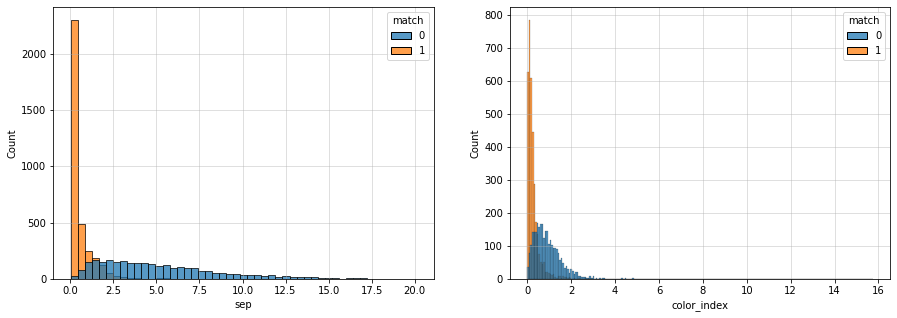

In [199]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=X0, x='sep', hue='match', alpha=.75, ax=ax[0])
sns.histplot(data=X0, x='color_index', hue='match', alpha=.75, ax=ax[1])

ax[0].grid(alpha=.5)
ax[1].grid(alpha=.5)

Так как признаки $f_{j}, e_{f_{j}}, где f=g, r, i, z$ и  $j=1, 2$ по сути своей задают доверительные интервалы $f_{j} \pm 3 e_{f_{j}}$ на магнитуды $f$ объектов, добавим ещё IoU (Intersection over Union), для отрезков $[f_{j} - k e_{f_{j}}], k=1, 2, 3$, где $k$ задает количество сигм в доверительном интервале

In [200]:
def IoU(row, filt, k):
    
    a1 = row[filt + '1'] - k*row['e_'+filt+'1']
    a2 = row[filt + '1'] + k*row['e_'+filt+'1']
    b1 = row[filt + '2'] - k*row['e_'+filt+'2']
    b2 = row[filt + '2'] + k*row['e_'+filt+'2']
    
    if a1 > b2 or a2 < b1:
        res = 0
        
    else:
        elements = np.sort(np.array((a1, a2, b1, b2)))
        inter = elements[-2] - elements[1]
        union = elements[-1] - elements[0]
        res = inter/union
            
    return res

In [201]:
# для трёх сигм

X0['IoU_g'] = data.apply(IoU, axis=1, args=('g', 2, )) 
X0['IoU_r'] = data.apply(IoU, axis=1, args=('r', 2, ))
X0['IoU_i'] = data.apply(IoU, axis=1, args=('i', 2, ))
X0['IoU_z'] = data.apply(IoU, axis=1, args=('z', 2, ))

X0['IoU_sum'] = X0['IoU_g'] + X0['IoU_r'] + X0['IoU_i'] + X0['IoU_z'] #суммарное

X0.reset_index(drop=True, inplace=True)

Последние четыре признака:

In [202]:
stat = pd.DataFrame()
stat['g_stat'] = np.sqrt((data.g1 - data.g2)**2/(2*data.e_g1**2 + 2*data.e_g2**2))
stat['r_stat'] = np.sqrt((data.r1 - data.r2)**2/(2*data.e_r1**2 + 2*data.e_r2**2))
stat['i_stat'] = np.sqrt((data.i1 - data.i2)**2/(2*data.e_i1**2 + 2*data.e_i2**2))
stat['z_stat'] = np.sqrt((data.r1 - data.z2)**2/(2*data.e_r1**2 + 2*data.e_z2**2))

stat.reset_index(drop=True, inplace=True)

In [203]:
# print('Данные о g-фильтре отутствуют в {} верно сопоставленных парах и в {} неверно сопоставленных'.format(data.loc[data['match'] == 1].d_g.isna().sum(), data.loc[data['match'] == 0].d_g.isna().sum()))
# print('Данные о r-фильтре отутствуют в {} верно сопоставленных парах и в {} неверно сопоставленных'.format(data.loc[data['match'] == 1].d_r.isna().sum(), data.loc[data['match'] == 0].d_r.isna().sum()))
# print('Данные о i-фильтре отутствуют в {} верно сопоставленных парах и в {} неверно сопоставленных'.format(data.loc[data['match'] == 1].d_i.isna().sum(), data.loc[data['match'] == 0].d_i.isna().sum()))
# print('Данные о z-фильтре отутствуют в {} верно сопоставленных парах и в {} неверно сопоставленных'.format(data.loc[data['match'] == 1].d_z.isna().sum(), data.loc[data['match'] == 0].d_z.isna().sum()))
# print('Отсутствие данных в хотя одном из фильтров наблюдается в {} верно сопоставленных парах и в {} неверно сопоставленных'.format(data.loc[data['match'] == 1].dd.isna().sum(), data.loc[data['match'] == 0].dd.isna().sum()))

In [204]:
Y0 = X0.pop('match').values.reshape(-1,1)
X0

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,...,d_r,d_i,d_z,dd,color_index,IoU_g,IoU_r,IoU_i,IoU_z,IoU_sum
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385,...,0.704846,0.966319,1.070175,1.605327,0.041058,0.161398,0.168539,0.521053,0.290198,1.141188
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342,...,0.789841,1.030181,1.161509,1.742084,0.043068,0.222693,0.128713,0.458333,0.391176,1.200915
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055,...,0.401086,0.512595,0.610707,0.893358,0.049409,0.000000,0.725000,0.000000,0.000000,0.725000
3,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,18.5408,0.0090,18.5585,0.0176,...,0.577095,0.752601,0.854770,1.276797,0.065815,0.000000,0.387560,0.525000,0.333333,1.245893
4,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,18.5390,0.0115,18.4372,0.0204,...,1.183075,1.598313,1.813897,2.694222,0.238915,0.000000,0.015782,0.000000,0.442308,0.458090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6371,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,19.5992,0.0242,19.3105,0.0134,...,2.325612,3.576867,4.125019,6.070248,0.379660,0.000000,0.000000,0.000000,0.000000,0.000000
6372,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,17.8211,0.0074,17.5721,0.0119,...,3.190030,4.254058,4.702842,7.263797,0.737553,0.000000,0.000000,0.000000,0.000000,0.000000
6373,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,19.3940,0.0345,19.2077,0.0463,...,1.704370,3.048214,3.608606,5.040349,1.459552,0.076579,0.000000,0.000000,0.000000,0.076579
6374,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,19.1681,0.0151,18.9094,0.0303,...,1.075705,2.247080,2.782066,3.785351,0.204945,0.000000,0.000000,0.000000,0.000000,0.000000


In [206]:
print('Без дальнейшей работы с признаками: {}'.format(score_dataset(X0, Y0, model=XGBClassifier()))) 

Без дальнейшей работы с признаками: 0.9639885361700944


Попробуем улучшить этот результат:

1. Уберём признаки, имеющие высокий показатель корреляции с другими признаками
2. Уберём признаки с низкой важностью
3. Добавим признаки-главные компоненты
4. Избавимся от выбросов

In [208]:
from feature_selector import FeatureSelector

1

4 features with a correlation magnitude greater than 0.98.



,drop_feature,corr_feature,corr_value
0,z1,i1,0.993047
1,y1,i1,0.983563
2,y1,z1,0.993290
3,d_z,d_i,0.993943
4,dd,d_r,0.989666
5,dd,d_i,0.991582


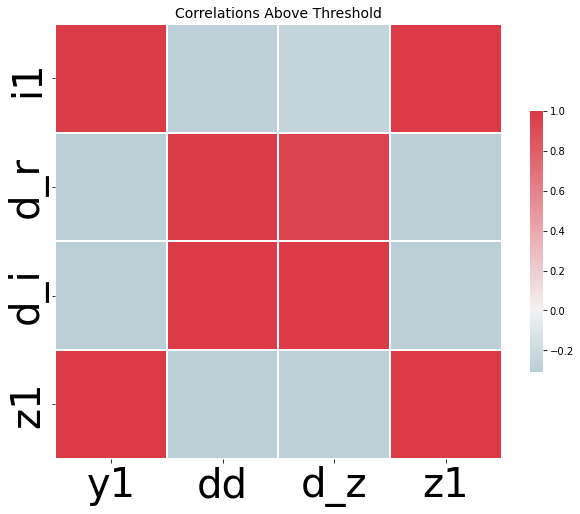

In [223]:
fs = FeatureSelector(data = X0, labels = Y0)

fs.identify_collinear(correlation_threshold = 0.98)
fs.plot_collinear()

fs.record_collinear

In [224]:
X1 = X0.drop(fs.record_collinear.drop_feature, axis=1)

In [225]:
print('С первым пунктом: {}'.format(score_dataset(X1, Y0, model=XGBClassifier()))) 

С первым пунктом: 0.9652056030605731


2

In [232]:
fs = FeatureSelector(data = X1, labels = Y0)

fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10)

Training Gradient Boosting Model



D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed i


0 features with zero importance after one-hot encoding.



In [238]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,sep,338.8,0.083407,0.083407
1,color_index,321.6,0.079173,0.162580
2,i1,243.6,0.059970,0.222550
3,e_i1,213.4,0.052536,0.275086
4,e_r1,210.3,0.051773,0.326859
5,e_i2,206.2,0.050763,0.377622
6,d_r,189.2,0.046578,0.424200
7,e_z2,161.8,0.039833,0.464032
8,d_g,142.1,0.034983,0.499015
9,z2,140.8,0.034663,0.533678


Отбросим последние три признака с наименьшей важностью 

In [243]:
X2 = X1.drop(fs.feature_importances.iloc[-3, :].feature, axis=1)
X2

,g1,e_g1,r1,e_r1,i1,e_i1,e_z1,u2,e_u2,g2,...,sep,d_g,d_r,d_i,color_index,IoU_g,IoU_r,IoU_i,IoU_z,IoU_sum
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,0.0208,21.389,0.098,20.155,...,0.094086,0.034901,0.704846,0.966319,0.041058,0.161398,0.168539,0.521053,0.290198,1.141188
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,0.0133,21.212,0.086,19.553,...,0.056274,0.025102,0.789841,1.030181,0.043068,0.222693,0.128713,0.458333,0.391176,1.200915
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,0.0031,17.763,0.012,16.801,...,0.056286,0.038766,0.401086,0.512595,0.049409,0.000000,0.725000,0.000000,0.000000,0.725000
3,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,0.0090,20.222,0.044,19.206,...,0.077395,0.011441,0.577095,0.752601,0.065815,0.000000,0.387560,0.525000,0.333333,1.245893
4,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,0.0115,22.341,0.204,20.132,...,0.213487,0.119746,1.183075,1.598313,0.238915,0.000000,0.015782,0.000000,0.442308,0.458090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6371,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,0.0242,23.244,0.440,23.393,...,4.061470,1.276588,2.325612,3.576867,0.379660,0.000000,0.000000,0.000000,0.000000,0.000000
6372,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,0.0074,22.327,0.383,22.232,...,4.643573,1.540365,3.190030,4.254058,0.737553,0.000000,0.000000,0.000000,0.000000,0.000000
6373,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,0.0345,24.303,1.491,22.695,...,3.476887,0.431968,1.704370,3.048214,1.459552,0.076579,0.000000,0.000000,0.000000,0.076579
6374,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,0.0151,24.937,0.856,21.677,...,1.114111,0.618452,1.075705,2.247080,0.204945,0.000000,0.000000,0.000000,0.000000,0.000000


In [244]:
print('С первыми двумя: {}'.format(score_dataset(X2, Y0, model=XGBClassifier()))) 

С первыми двумя: 0.9656730464890704


3

Добавим главных компонент 

In [272]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    
    return axs

In [273]:
X0.head(3)

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,...,d_r,d_i,d_z,dd,color_index,IoU_g,IoU_r,IoU_i,IoU_z,IoU_sum
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,19.3065,0.0208,19.2360,0.0385,...,0.704846,0.966319,1.070175,1.605327,0.041058,0.161398,0.168539,0.521053,0.290198,1.141188
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,18.5928,0.0133,18.5634,0.0342,...,0.789841,1.030181,1.161509,1.742084,0.043068,0.222693,0.128713,0.458333,0.391176,1.200915
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,16.2985,0.0031,16.2864,0.0055,...,0.401086,0.512595,0.610707,0.893358,0.049409,0.000000,0.725000,0.000000,0.000000,0.725000


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

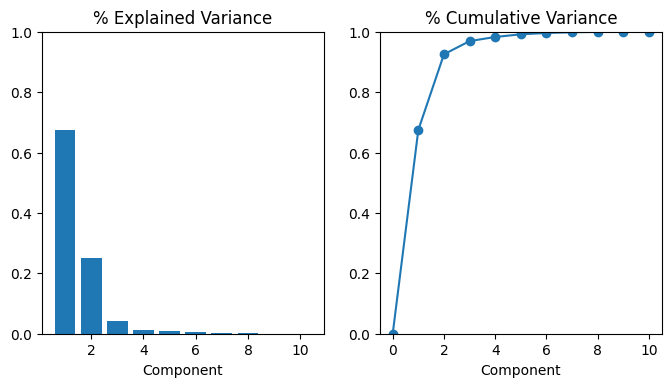

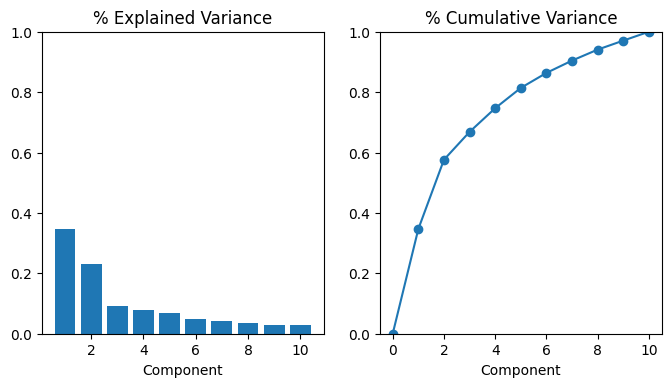

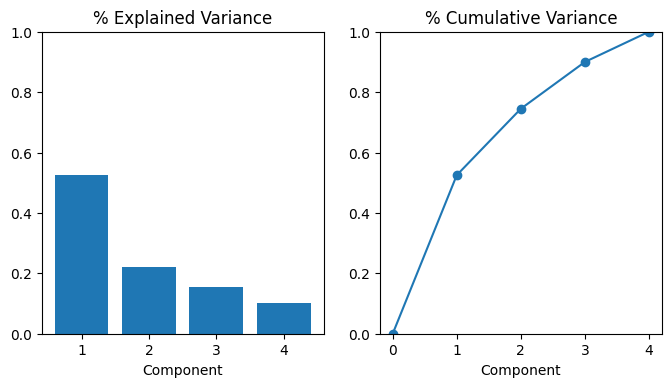

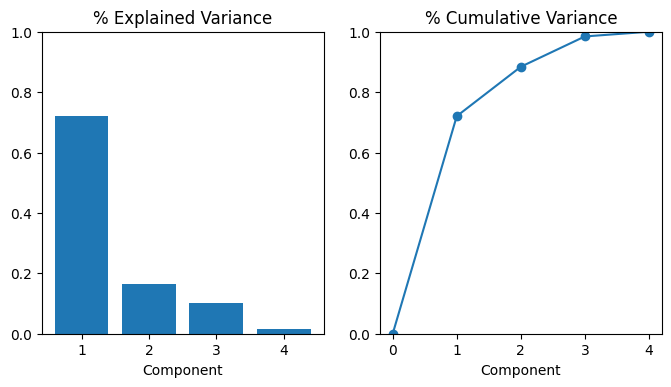

In [274]:
X_pca_f = apply_pca(X0.iloc[:, ::2].iloc[:, :10])
X_pca_ef = apply_pca(X0.iloc[:, 1::2].iloc[:, :10])
X_pca_IoU = apply_pca(X0.iloc[:, 27:31])
X_pca_stat = apply_pca(X0.iloc[:, -4:])

plot_variance(X_pca_f[0])
plot_variance(X_pca_ef[0])
plot_variance(X_pca_IoU[0])
plot_variance(X_pca_stat[0])

In [275]:
X_pca_f[1].rename(columns={'PC1':'PC1_f', 'PC2':'PC2_f'}, inplace=True)
X_pca_ef[1].rename(columns={'PC1':'PC1_ef', 'PC2':'PC2_ef'}, inplace=True)
X_pca_IoU[1].rename(columns={'PC1':'PC1_IoU', 'PC2':'PC2_IoU'}, inplace=True)
X_pca_stat[1].rename(columns={'PC1':'PC1_stat', 'PC2':'PC2_stat'}, inplace=True)

Добавим несколько компонент

In [292]:
X3 = X2.reset_index(drop=True).join(X_pca_f[1][['PC1_f', 'PC2_f']]).join(X_pca_IoU[1][['PC1_IoU', 'PC2_IoU']]).join(X_pca_stat[1][['PC1_stat']])
X3

,g1,e_g1,r1,e_r1,i1,e_i1,e_z1,u2,e_u2,g2,...,IoU_g,IoU_r,IoU_i,IoU_z,IoU_sum,PC1_f,PC2_f,PC1_IoU,PC2_IoU,PC1_stat
0,20.1046,0.0169,19.6244,0.0038,19.3938,0.0099,0.0208,21.389,0.098,20.155,...,0.161398,0.168539,0.521053,0.290198,1.141188,0.302137,-0.815016,2.055977,-0.127375,2.419539
1,19.5071,0.0231,18.9146,0.0071,18.6990,0.0055,0.0133,21.212,0.086,19.553,...,0.222693,0.128713,0.458333,0.391176,1.200915,1.410590,-0.661963,2.236324,0.436213,2.517644
2,16.7566,0.0046,16.4471,0.0029,16.3323,0.0021,0.0031,17.763,0.012,16.801,...,0.000000,0.725000,0.000000,0.000000,0.725000,5.783297,-0.542046,0.799766,-1.169684,1.196455
3,19.1318,0.0223,18.7672,0.0045,18.6129,0.0063,0.0090,20.222,0.044,19.206,...,0.000000,0.387560,0.525000,0.333333,1.245893,1.755404,-0.776172,2.452229,-1.247547,3.169002
4,19.9275,0.0343,19.1223,0.0057,18.7377,0.0056,0.0115,22.341,0.204,20.132,...,0.000000,0.015782,0.000000,0.442308,0.458090,1.083656,-0.485973,0.394766,0.309209,0.486403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6371,21.9542,0.1682,21.3643,0.0228,20.1769,0.0192,0.0242,23.244,0.440,23.393,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.737134,0.711330,-1.099057,-0.049400,-1.263465
6372,20.5570,0.0098,19.2949,0.0072,18.2829,0.0036,0.0074,22.327,0.383,22.232,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.054034,1.251736,-1.099057,-0.049400,-1.263465
6373,22.1174,0.1487,21.2611,0.0355,19.9740,0.0171,0.0345,24.303,1.491,22.695,...,0.076579,0.000000,0.000000,0.000000,0.076579,-2.516488,0.654621,-0.942544,0.336067,-1.181414
6374,22.1740,0.1109,20.8332,0.0137,19.7082,0.0119,0.0151,24.937,0.856,21.677,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.897616,-0.674329,-1.099057,-0.049400,-1.263465


In [293]:
print('Первые три: {}'.format(score_dataset(X3, Y0, model=XGBClassifier()))) 

Первые три: 0.9668375604336182


Ещё одна небольшая правка

In [367]:
X3_1 = X3.drop(['u2', 'e_u2'], axis=1)

score_dataset(X3_1, Y0, model=XGBClassifier())

0.9670281431189229

4

Один и тот же объект (класс 1) в разные моменты наблюдения мог испытывать изменения, повлекшие его поярчание или потускнение в том или ином фильтре. Такая пара будет иметь неестественно большое $sep$ вместе с $CI_{sep}$ (пара 817 и 3301 в таблице ниже), классификация таких объектов нам ни к чему, поэтому избавимся от них

In [368]:
X3_1['match'] = Y0
ot = X3_1.copy()

index = ot.loc[ot['match'] == 1].sep.sort_values(ascending=False).index

ot.iloc[index].iloc[:, 10:].head(5)

,e_r2,i2,e_i2,z2,e_z2,sep,d_g,d_r,d_i,color_index,...,IoU_r,IoU_i,IoU_z,IoU_sum,PC1_f,PC2_f,PC1_IoU,PC2_IoU,PC1_stat,match
817,0.231,30.947,0.166,28.388,0.402,14.531450,4.513792,3.347631,2.769265,13.074640,...,0.0,0.0,0.0,0.0,-4.472570,2.399227,-1.099057,-0.0494,-1.263465,1
2555,0.030,16.690,0.027,17.224,0.164,8.494788,4.263490,3.412968,3.106227,0.455810,...,0.0,0.0,0.0,0.0,0.264513,-4.406781,-1.099057,-0.0494,-1.263465,1
3301,0.011,17.262,0.011,18.436,0.094,7.508129,6.924426,8.003829,8.337974,8.639269,...,0.0,0.0,0.0,0.0,0.253090,0.267480,-1.099057,-0.0494,-1.263465,1
1133,0.002,14.668,0.007,20.287,0.267,7.231957,1.398382,2.093847,2.325370,1.845195,...,0.0,0.0,0.0,0.0,8.222701,2.402255,-1.099057,-0.0494,-1.263465,1
257,0.569,24.362,0.713,20.420,0.167,6.775400,3.031710,4.822609,5.381694,0.914477,...,0.0,0.0,0.0,0.0,-3.360661,1.594829,-1.099057,-0.0494,-1.263465,1


In [400]:
outliers_ind = ot.loc[(ot['match'] == 1) & (ot['sep']>5) & (ot['color_index']>5)].index

In [401]:
X4 = X3_1.copy()
X4 = X3_1.drop(labels=outliers_ind, axis=0)
Y4 = X4.pop('match')

In [403]:
print('Все пункты: {}'.format(score_dataset(X4, Y4, model=XGBClassifier()))) 

Все пункты: 0.9665629396724731


Подберём гиперпараметры модели

In [ ]:
param_grid = {'max_depth': [3,4,5],
             'learning_rate': [.1, .01, .05],
             'gamma': [0,1,10],
             'reg_lambda': [0, 1,10],
             'scale_pos_weight': [1,3,5]}

In [337]:
X3_1['match'] = Y0
ot = X3_1.copy()

# fig, ax = plt.subplots(figsize=(8,8))
# sns.histplot(data=ot.loc[ot['match'] == 1], x='sep', ax=ax)

index = ot.loc[ot['match'] == 1].sep.sort_values(ascending=False).index
index

ot.iloc[index].iloc[:, 10:].head(5)

,e_r2,i2,e_i2,z2,e_z2,sep,d_g,d_r,d_i,color_index,...,IoU_r,IoU_i,IoU_z,IoU_sum,PC1_f,PC2_f,PC1_IoU,PC2_IoU,PC1_stat,match
817,0.231,30.947,0.166,28.388,0.402,14.531450,4.513792,3.347631,2.769265,13.074640,...,0.0,0.0,0.0,0.0,-4.472570,2.399227,-1.099057,-0.0494,-1.263465,1
2555,0.030,16.690,0.027,17.224,0.164,8.494788,4.263490,3.412968,3.106227,0.455810,...,0.0,0.0,0.0,0.0,0.264513,-4.406781,-1.099057,-0.0494,-1.263465,1
3301,0.011,17.262,0.011,18.436,0.094,7.508129,6.924426,8.003829,8.337974,8.639269,...,0.0,0.0,0.0,0.0,0.253090,0.267480,-1.099057,-0.0494,-1.263465,1
1133,0.002,14.668,0.007,20.287,0.267,7.231957,1.398382,2.093847,2.325370,1.845195,...,0.0,0.0,0.0,0.0,8.222701,2.402255,-1.099057,-0.0494,-1.263465,1
257,0.569,24.362,0.713,20.420,0.167,6.775400,3.031710,4.822609,5.381694,0.914477,...,0.0,0.0,0.0,0.0,-3.360661,1.594829,-1.099057,-0.0494,-1.263465,1


In [ ]:
ot.color_index.mean() + 5*ot.color_index.std()

In [158]:
X2_new = X2.drop(labels=fs2.record_collinear.drop_feature, axis=1)

In [159]:
%%time

score_dataset(X2_new, Y0.ravel(), model=XGBClassifier())

Wall time: 6.4 s


0.9690315191256149

In [ ]:
0.9690315191256149

In [601]:
# from sklearn.feature_selection import RFE

# rfe = RFE(estimator=XGBClassifier(),  n_features_to_select=5) 
# selector = rfe.fit(X1,Y0)

<AxesSubplot:>

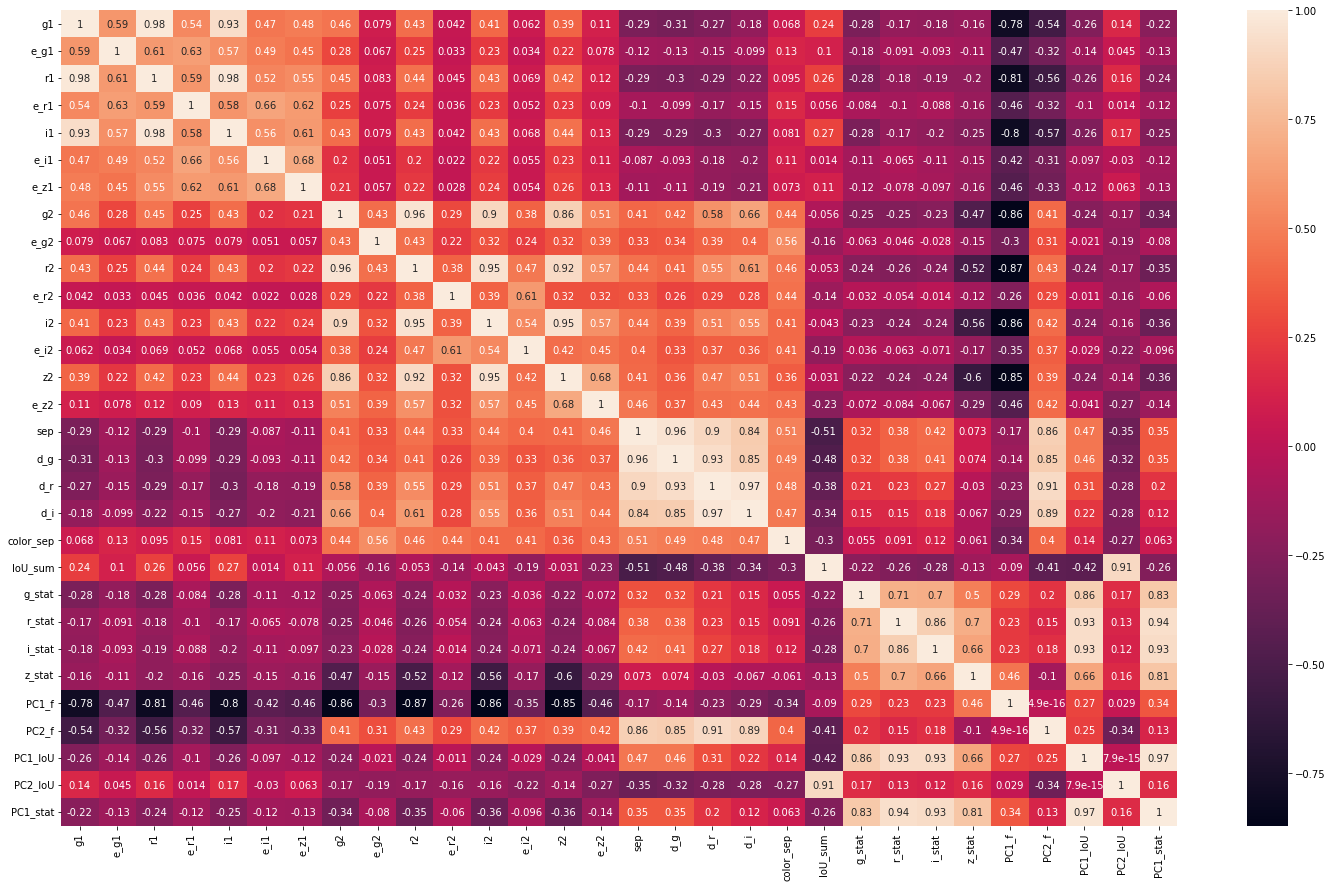

In [132]:
fig, ax = plt.subplots(figsize=(25,15))

sns.heatmap(X2_new.corr(), annot=True, ax=ax)

In [649]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X2)
umap_df = pd.DataFrame(np.concatenate((embedding, Y0), axis=1), columns=['component1', 'component2', 'target'])

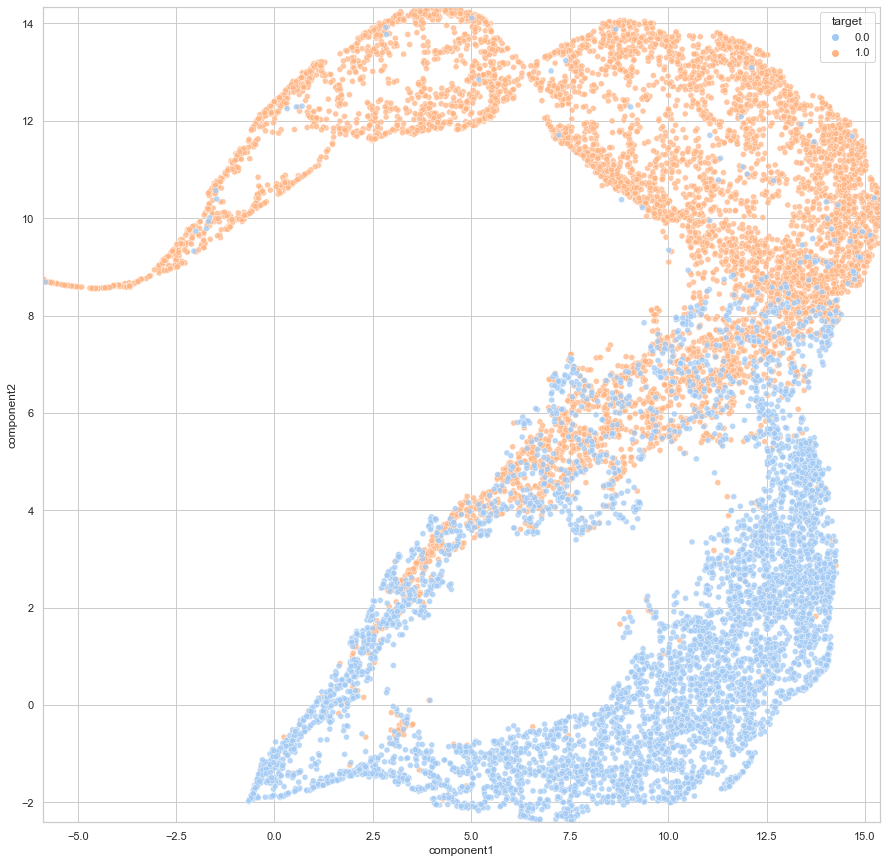

In [722]:
fig, ax = plt.subplots(figsize=(15,15)) 

sns.scatterplot(x="component1", y="component2", alpha=.75, hue="target", data=umap_df, ax=ax)

marg=0
plt.margins(-marg, -marg)

In [723]:
X

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,u2,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,21.8443,0.1552,21.4675,0.0244,20.8086,0.0207,20.4632,0.0897,19.9323,0.1280,24.273,0.958,22.451,0.128,21.041,0.059,20.405,0.051,19.810,0.102
1,19.4059,0.0137,18.8146,0.0037,18.5630,0.0047,18.4580,0.0087,18.3596,0.0176,21.094,0.084,19.494,0.012,18.819,0.010,18.552,0.011,18.419,0.030
2,22.0068,0.0634,20.9774,0.0189,19.3737,0.0116,18.6224,0.0123,18.2760,0.0185,24.706,0.720,22.325,0.088,20.901,0.041,19.332,0.017,18.467,0.026
8,16.9785,0.0064,16.5817,0.0029,16.4347,0.0021,16.4029,0.0058,16.3688,0.0074,18.380,0.016,17.045,0.005,16.572,0.004,16.426,0.005,16.363,0.008
9,21.2735,0.0440,20.4857,0.0155,20.1390,0.0292,19.9622,0.0223,19.8732,0.0678,23.360,0.471,21.334,0.043,20.416,0.030,20.146,0.034,19.773,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35524,21.7286,0.0680,21.1986,0.0398,20.7526,0.0630,20.5573,0.0674,20.6226,0.1718,20.867,0.127,19.402,0.015,18.532,0.011,18.119,0.012,17.755,0.028
35525,15.7531,0.0112,14.5551,0.0021,13.9203,0.0027,13.6130,0.0024,13.4592,0.0028,25.146,1.177,24.592,0.679,22.506,0.194,21.912,0.175,21.754,0.574
35526,19.9130,0.0104,18.7235,0.0075,18.1188,0.0042,17.8438,0.0128,17.6644,0.0019,24.602,1.321,24.017,0.461,22.531,0.189,21.996,0.187,21.623,0.443
35527,20.3868,0.0147,19.9929,0.0155,19.8335,0.0093,19.7584,0.0215,19.6825,0.0424,23.183,0.883,22.977,0.281,21.628,0.147,21.000,0.125,20.643,0.317


In [130]:
X_train, X_test, Y_train, Y_test = train_test_split(X2_new, Y0, test_size=.33, random_state=41)
X_train

,g1,e_g1,r1,e_r1,i1,e_i1,e_z1,g2,e_g2,r2,...,IoU_sum,g_stat,r_stat,i_stat,z_stat,PC1_f,PC2_f,PC1_IoU,PC2_IoU,PC1_stat
424,18.6930,0.0133,17.9231,0.0018,17.6095,0.0044,0.0047,18.812,0.009,17.917,...,0.479663,5.239800,0.596779,1.240086,27.052550,2.982188,-0.539022,-0.546465,-0.003339,-0.396833
5710,19.4048,0.0229,19.0235,0.0052,18.8824,0.0098,0.0117,21.605,0.050,20.255,...,0.000000,28.289602,35.460623,21.186175,4.157126,0.321296,0.464426,0.920130,-0.520576,0.459355
344,21.5658,0.0409,20.9622,0.0659,20.7828,0.1110,0.1419,21.432,0.058,20.675,...,0.349845,1.333102,2.508931,2.835243,4.966034,-1.332116,-1.513724,-0.510121,-0.250779,-0.685591
5306,21.2300,0.1271,21.1284,0.0545,20.9598,0.0416,0.1546,22.902,0.170,21.907,...,0.147999,5.569967,5.190378,4.546151,0.313027,-2.481988,-0.435513,-0.267414,-0.568989,-0.609391
4288,22.3961,0.0087,21.6704,0.0217,21.1683,0.0202,0.0665,22.551,0.167,22.425,...,0.450137,0.654985,2.223418,1.226171,3.214241,-2.657806,-1.290313,-0.599048,-0.081671,-0.744100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,22.0944,0.0974,20.6011,0.0434,19.7045,0.0233,0.0346,22.980,0.155,21.677,...,0.000000,3.420771,9.838351,15.358677,1.119105,-1.695097,-0.103696,-0.014605,-0.798369,-0.429791
4066,20.6717,0.0272,19.3987,0.0067,18.1937,0.0039,0.0074,23.775,0.320,22.357,...,0.000000,6.832750,17.698900,39.486106,5.681112,-0.850887,2.084850,0.515862,-0.671373,0.114312
3980,18.0321,0.0033,17.2818,0.0032,17.0027,0.0026,0.0050,19.984,0.016,18.983,...,0.000000,84.484379,105.004344,94.982063,27.322494,2.537659,1.305082,4.082666,0.339395,3.637186
931,20.3988,0.0232,19.7555,0.0118,19.4887,0.0055,0.0300,20.588,0.030,19.765,...,0.709216,3.527690,0.289279,1.591994,6.387279,0.202018,-1.031480,-0.689319,0.396575,-0.676293


Accuracy: 0.9695961995249406
Precision: 0.9733905579399141
F_beta: 0.973056461300841


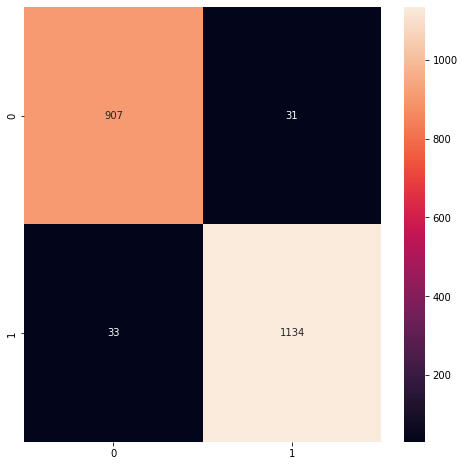

In [131]:
fbeta_scorer = make_scorer(fbeta_score, beta=.5, pos_label=1) 

model1 = XGBClassifier()

model1.fit(X_train, Y_train.ravel())

cf_matrix1 = confusion_matrix(Y_test, model1.predict(X_test))

fig, ax =plt.subplots(figsize=(8,8))

sns.heatmap(cf_matrix1, annot=True, fmt='.4g', ax=ax)
print('Accuracy: {}'.format(accuracy_score(Y_test, model1.predict(X_test))))
print('Precision: {}'.format(precision_score(Y_test, model1.predict(X_test))))
print('F_beta: {}'.format(fbeta_scorer(model1, X=X_test, y_true=Y_test)))

In [633]:
X = data.copy()
y = X.pop('match')
X

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,u2,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,21.8443,0.1552,21.4675,0.0244,20.8086,0.0207,20.4632,0.0897,19.9323,0.1280,24.273,0.958,22.451,0.128,21.041,0.059,20.405,0.051,19.810,0.102
1,19.4059,0.0137,18.8146,0.0037,18.5630,0.0047,18.4580,0.0087,18.3596,0.0176,21.094,0.084,19.494,0.012,18.819,0.010,18.552,0.011,18.419,0.030
2,22.0068,0.0634,20.9774,0.0189,19.3737,0.0116,18.6224,0.0123,18.2760,0.0185,24.706,0.720,22.325,0.088,20.901,0.041,19.332,0.017,18.467,0.026
8,16.9785,0.0064,16.5817,0.0029,16.4347,0.0021,16.4029,0.0058,16.3688,0.0074,18.380,0.016,17.045,0.005,16.572,0.004,16.426,0.005,16.363,0.008
9,21.2735,0.0440,20.4857,0.0155,20.1390,0.0292,19.9622,0.0223,19.8732,0.0678,23.360,0.471,21.334,0.043,20.416,0.030,20.146,0.034,19.773,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35524,21.7286,0.0680,21.1986,0.0398,20.7526,0.0630,20.5573,0.0674,20.6226,0.1718,20.867,0.127,19.402,0.015,18.532,0.011,18.119,0.012,17.755,0.028
35525,15.7531,0.0112,14.5551,0.0021,13.9203,0.0027,13.6130,0.0024,13.4592,0.0028,25.146,1.177,24.592,0.679,22.506,0.194,21.912,0.175,21.754,0.574
35526,19.9130,0.0104,18.7235,0.0075,18.1188,0.0042,17.8438,0.0128,17.6644,0.0019,24.602,1.321,24.017,0.461,22.531,0.189,21.996,0.187,21.623,0.443
35527,20.3868,0.0147,19.9929,0.0155,19.8335,0.0093,19.7584,0.0215,19.6825,0.0424,23.183,0.883,22.977,0.281,21.628,0.147,21.000,0.125,20.643,0.317


In [641]:
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(X, y, test_size=.25, random_state=42)
X_train0

,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1,y1,e_y1,u2,e_u2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
18819,20.9451,0.0717,20.4771,0.0390,19.8353,0.0516,19.9034,0.0830,19.4320,0.1451,24.297,0.953,23.274,0.198,21.972,0.095,21.030,0.072,20.796,0.241
28914,20.6647,0.0773,19.9381,0.0322,19.4123,0.0458,19.0373,0.0482,19.6430,0.0099,23.662,0.859,21.860,0.076,21.296,0.063,22.313,0.226,22.137,0.648
32221,22.0009,0.0463,21.4973,0.0313,21.2342,0.0294,21.2890,0.1779,19.9459,0.1807,24.587,0.901,22.554,0.120,21.404,0.058,20.631,0.046,20.275,0.113
34125,20.3184,0.0527,19.7586,0.0083,19.5204,0.0095,19.4155,0.0323,19.3176,0.0292,23.900,0.674,23.105,0.182,21.415,0.056,20.728,0.052,20.371,0.154
21619,20.3450,0.0155,20.1244,0.0082,20.0244,0.0139,20.0246,0.0244,19.8579,0.0463,24.860,1.160,23.088,0.249,22.442,0.175,22.909,0.395,21.823,0.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12120,22.2247,0.1849,21.9646,0.0534,20.9379,0.0233,20.1465,0.0655,19.9591,0.1218,24.934,0.886,23.403,0.222,21.941,0.097,20.847,0.062,20.240,0.140
34051,20.4327,0.1101,19.6535,0.0315,19.5530,0.0508,18.9882,0.0626,19.3068,0.0293,19.409,0.026,18.415,0.007,18.110,0.007,18.046,0.008,17.964,0.022
12627,17.9455,0.0028,16.7533,0.0025,15.6223,0.0020,15.1154,0.0097,14.8861,0.0066,20.870,0.073,18.168,0.006,16.732,0.005,15.616,0.004,15.002,0.005
2000,19.1379,0.0101,17.9661,0.0049,17.1550,0.0040,16.7744,0.0047,16.5507,0.0063,22.342,0.236,19.405,0.012,18.023,0.007,17.256,0.006,16.682,0.010


<AxesSubplot:>

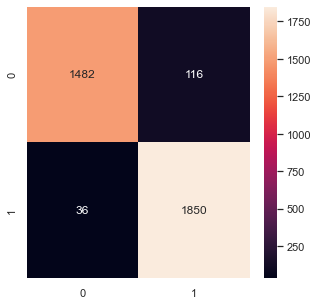

In [642]:
model1.fit(X_train0, Y_train0.ravel())
cf_matrix1 = confusion_matrix(Y_test0, model1.predict(X_test0))

fig, ax =plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix1, annot=True, fmt='.4g', ax=ax)

In [640]:
score_dataset(X, y, model=XGBClassifier())

0.9538194506919868

## Модель

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import umap.umap_ as umap

from sklearn.metrics import confusion_matrix, fbeta_score, mean_squared_log_error

In [ ]:
X = data.copy()
y = X.pop('match')
X

Признаки $r_{i}, e_{r_{i}}$ задают доверительные интервалы $r_{i} \pm 3 e_{r_{i}}$ для магнитуд $r$ объектов таблицы, добавим новые признаки, которые смогут помочь модели: 


$X_{1, 2, 3}$ - тот же IoU (Intersection over Union), только для отрезков $[r_{i} - k e_{r_{i}}], k=1, 2, 3$

In [ ]:
def IoU(row, k): # k задаёт количество "сигм" в доверительном интервале
    
    a1 = row.r1 - k*row.e_r1
    a2 = row.r1 + k*row.e_r1
    b1 = row.r2 - k*row.e_r2
    b2 = row.r2 + k*row.e_r2
    
    if a1 > b2 or a2 < b1:
        res = 0
        
    else:
        elements = np.sort(np.array((a1, a2, b1, b2)))
        inter = elements[-2] - elements[1]
        union = elements[-1] - elements[0]
        res = inter/union
            
    return res

In [ ]:
X_1 = data.apply(IoU, axis=1, args=(1,))
X_2 = data.apply(IoU, axis=1, args=(2,))
X_3 = data.apply(IoU, axis=1, args=(3,))

$X_4$ - кол-во ненулевых IoU в  паре

In [ ]:
daframe = pd.DataFrame()
daframe['IoU_1'] = X_1
daframe['IoU_2'] = X_2
daframe['IoU_3'] = X_3

X_4 = daframe[['IoU_1', 'IoU_2', 'IoU_3']].gt(0).sum(axis=1)

$X_5$

In [ ]:
X_5 = (X.r1 - X.r2)**2/(2*X.e_r1**2 + 2*X.e_r2**2)

$X_6$ - увеличение IoU (да/нет)

In [ ]:
X_6 = 1*(np.round(daframe.IoU_2, 3).gt(np.round(daframe.IoU_1, 3)) | np.round(daframe.IoU_3, 3).gt(np.round(daframe.IoU_2, 3)))

In [ ]:
X['f1'] = X_1
X['f2'] = X_2
X['f3'] = X_3
X['f4'] = X_4
X['f5'] = X_5
X['f6'] = X_6
X

Проверка корреляций

In [ ]:
cor = X.corr()

sns.heatmap(cor)
sns.set(rc = {'figure.figsize':(7, 5)})

In [17]:
X_upd = X.drop(['f1', 'f2', 'f3'], axis=1)

cor_upd = X_upd.corr()

sns.heatmap(cor_upd)
sns.set(rc = {'figure.figsize':(7, 5)})

NameError: name 'X' is not defined

In [24]:
X_i=np.array((X_upd))
Y=np.array((y))

Y_i=np.reshape(Y, (len(Y), 1))

sc = StandardScaler()
sc.fit(X_i)
X_i=sc.transform(X_i)

Двумерная визуализация разделимости классов с UMAP

In [28]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X_i)
umap_df = pd.DataFrame(np.concatenate((embedding, Y_i), axis=1), columns=['component1', 'component2', 'target'])

In [27]:
mapper = umap.UMAP().fit(X_i)
umap.plot.points(mapper, labels=Y_i, theme='fire')

AttributeError: module 'umap.umap_' has no attribute 'plot'

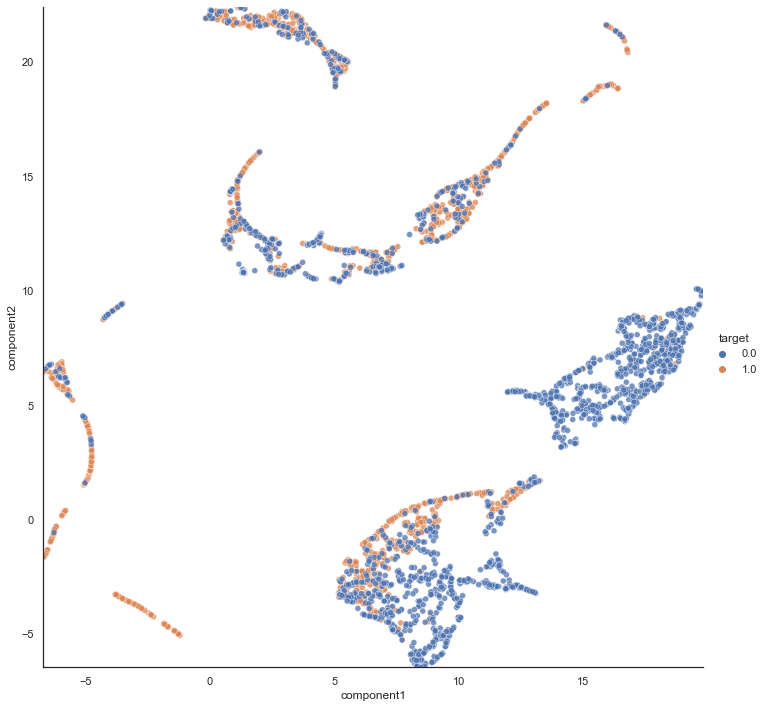

In [131]:
sns.set(rc = {'figure.figsize':(4, 4.5)})
sns.set_theme(style="white")
sns.relplot(x="component1", y="component2", alpha=.75, hue="target", data=umap_df, height=10)
# plt.ylim(-7, 7)
# plt.xlim(-5, 5)

marg=0
plt.margins(-marg, -marg)

Учимся

In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y, test_size=.25, random_state=47)

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

ml_svm = svm.SVC(kernel='rbf', probability=True) 

# logreg=LogisticRegression()
# knn = KNeighborsClassifier()

fbeta_scorer = make_scorer(fbeta_score, beta=.5, pos_label=1) 

In [138]:
# search_space_poly = {'C': [0.1, 1, 10],
#               'kernel': ['poly'],
#               'gamma': [0.1, 1, 10],
#               'degree': [3]} 

# search_space_knn = {'n_neighbors': list(range(1, 6)),
#                  'weights': ['uniform', 'distance'],
#                  'metric': ['minkowski','euclidean', 'manhattan']}

# search_space_logreg={'C': [0.0001, 0.001, 0.01, 0.1, 1],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               'penalty': ['l1', 'l2', 'elasticnet'],}

In [143]:
search_space_rbf = {'C': [1, 10], 
              'gamma': [20, 30, 40],
              'kernel': ['rbf']} 

grid = GridSearchCV(ml_svm, search_space_rbf, refit=True, verbose = 3, cv=5, scoring=fbeta_scorer)
grid_search=grid.fit(X_train, Y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........C=1, gamma=20, kernel=rbf;, score=0.847 total time=   1.3s
[CV 2/5] END .........C=1, gamma=20, kernel=rbf;, score=0.841 total time=   1.3s
[CV 3/5] END .........C=1, gamma=20, kernel=rbf;, score=0.841 total time=   1.3s
[CV 4/5] END .........C=1, gamma=20, kernel=rbf;, score=0.831 total time=   1.2s
[CV 5/5] END .........C=1, gamma=20, kernel=rbf;, score=0.820 total time=   1.2s
[CV 1/5] END .........C=1, gamma=30, kernel=rbf;, score=0.851 total time=   1.4s
[CV 2/5] END .........C=1, gamma=30, kernel=rbf;, score=0.845 total time=   1.4s
[CV 3/5] END .........C=1, gamma=30, kernel=rbf;, score=0.846 total time=   1.4s
[CV 4/5] END .........C=1, gamma=30, kernel=rbf;, score=0.840 total time=   1.5s
[CV 5/5] END .........C=1, gamma=30, kernel=rbf;, score=0.822 total time=   1.5s
[CV 1/5] END .........C=1, gamma=40, kernel=rbf;, score=0.848 total time=   1.6s
[CV 2/5] END .........C=1, gamma=40, kernel=rbf;,

In [144]:
Y_pred = grid.predict(X_test)

fbeta_score(Y_test.tolist(), Y_pred.tolist(), beta = .5)

0.8562874251497006

In [145]:
cf_matrix = confusion_matrix(Y_test.tolist(), Y_pred.tolist())
cf_matrix

array([[436,  66],
       [ 96, 429]], dtype=int64)

XGBoost

In [146]:
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [147]:
fbeta_score(Y_test.tolist(), model.predict(X_test).tolist(), beta = .5)

0.8644946316179191

RandomForest

In [148]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)


RandomForestClassifier(random_state=0)

In [149]:
fbeta_score(Y_test.tolist(), clf.predict(X_test).tolist(), beta = .5)

0.8552388004442799

In [151]:
cf_matrix = confusion_matrix(Y_test.tolist(), clf.predict(X_test).tolist())
cf_matrix

array([[420,  82],
       [ 63, 462]], dtype=int64)

Тюнинг гиперпараметров впереди

Ctrl+s

In [68]:
import joblib

joblib.dump(grid, obs_name + ".save") 

['Maidanak.save']